#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Atributos sintéticas y valores atípicos

 **Objetivos de aprendizaje:**
  * crear un atributo sintético que sea la proporción de otros dos atributos
  * usar este atributo nuevo como una entrada para un modelo de regresión lineal
  * mejorar la eficacia del modelo al identificar valores atípicos y aplicarles un límite (quitarlos) de los datos de entrada

 Revisemos nuestro modelo del ejercicio anterior "Primeros pasos con TensorFlow". 

Primero, importaremos los datos de viviendas en California a un `DataFrame` de *Pandas*:

 ## Preparación

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep = ",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3118,-117.8,33.7,3.0,7105.0,1459.0,3068.0,1241.0,6.1,358.0
4966,-118.1,34.0,23.0,3436.0,565.0,1729.0,529.0,6.0,266.7
1962,-117.3,33.1,14.0,2670.0,426.0,1034.0,407.0,6.4,295.1
14741,-122.2,37.8,19.0,2207.0,565.0,1481.0,520.0,1.3,81.4
13602,-122.0,38.0,16.0,2984.0,406.0,1317.0,397.0,6.8,265.9
...,...,...,...,...,...,...,...,...,...
9355,-119.2,35.4,12.0,2835.0,471.0,1399.0,413.0,4.4,149.0
1969,-117.3,34.4,16.0,5130.0,1172.0,3126.0,1046.0,1.7,71.9
732,-117.0,32.6,21.0,6034.0,1205.0,3795.0,1146.0,3.3,129.7
14164,-122.1,37.6,16.0,1644.0,251.0,1033.0,267.0,6.5,244.3


In [17]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3,0.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0,0.1
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.1
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4,0.2
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4,0.3
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0,0.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0,5.0


 A continuación, configuraremos nuestra función de entrada y definiremos la función para el entrenamiento del modelo:

In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature):
    """Trains a linear regression model.
  
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
            to use as input feature.
      
    Returns:
        A Pandas `DataFrame` containing targets and the corresponding predictions done
        after training the model.
    """
  
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')

    # Create input functions.
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs = 1, shuffle = False)
  
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n = 300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Create a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
    return calibration_data

 ## Tarea 1: Prueba un atributo sintético

Los atributos `total_rooms` y `population` cuentan los totales para una manzana específica.

Pero, ¿qué ocurriría si una manzana estuviese más densamente poblada que otra? Podemos explorar cómo se relaciona la densidad de las manzanas con el valor mediano de las casas al crear un atributo sintético que sea una proporción de `total_rooms` y `population`.

En la celda a continuación, crea un atributo denominado `rooms_per_person` y úsalo como la `input_feature` para `train_model()`.

¿Cuál es el mejor rendimiento que puedes obtener con este único atributo al ajustar la tasa de aprendizaje? (Cuanto mejor sea el rendimiento, mejor se ajustará la línea de regresión a los datos y más baja será la RMSE final).

 **NOTA**: Es posible que te resulte útil agregar algunas celdas de código a continuación para probar varias tasas de aprendizaje diferentes y comparar los resultados. Para agregar una celda de código nueva, desplaza el cursor directamente debajo del centro de esta celda y haz clic en **CODE** (CÓDIGO).

In [0]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
)

Training model...
RMSE (on training data):
  period 09 : 237.29
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,0.3,207.3
std,0.1,116.0
min,0.1,15.0
25%,0.2,119.4
50%,0.3,180.4
75%,0.3,265.0
max,6.2,500.0


Final RMSE (on training data): 237.29


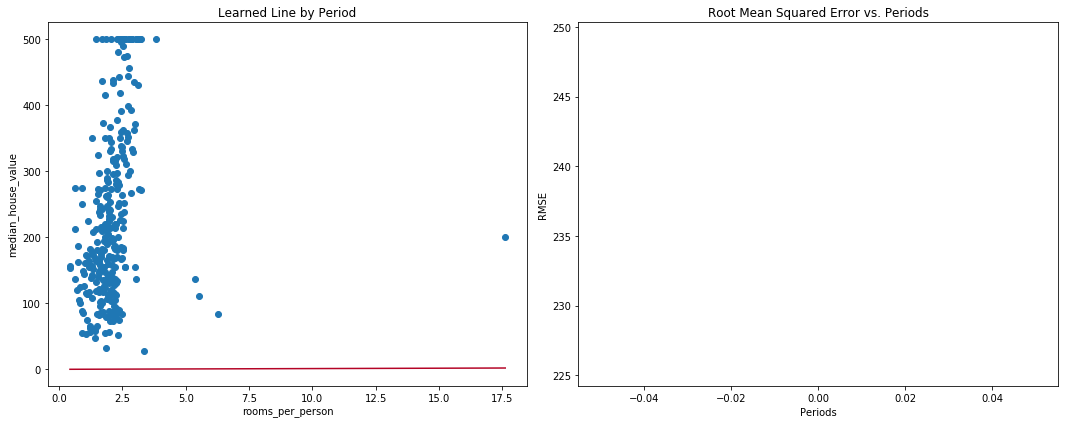

In [19]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] = calibration_data = train_model(
    learning_rate = 0.00005,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

 ### Solución

Haz clic más abajo para conocer la solución.

Training model...
RMSE (on training data):
  period 09 : 140.69
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,127.8,207.3
std,4.3,116.0
min,120.6,15.0
25%,126.1,119.4
50%,127.7,180.4
75%,129.0,265.0
max,322.8,500.0


Final RMSE (on training data): 140.69


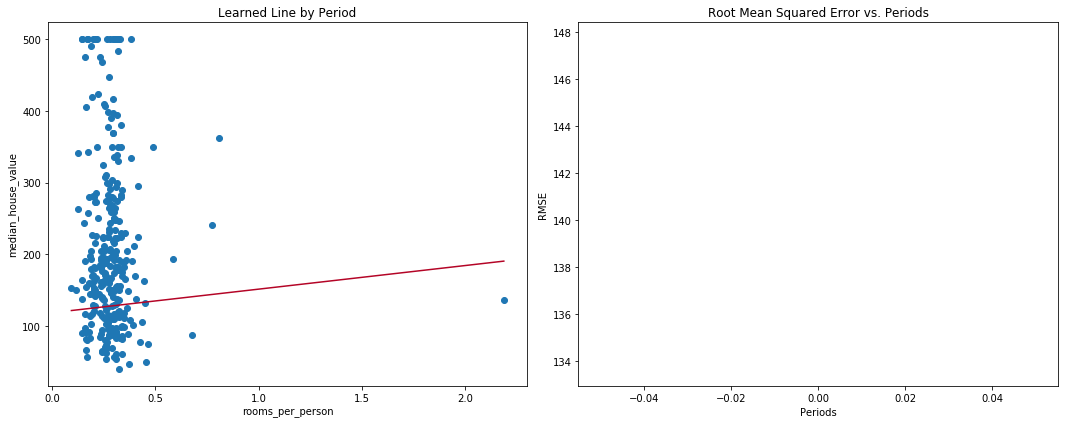

In [20]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

 ## Tarea 2: Identifica valores atípicos

Para visualizar el rendimiento del modelo, podemos crear una representación de dispersión de las predicciones frente a los valores objetivo. Idealmente, estos deberían estar en una línea diagonal perfectamente correlacionada.

Usa `scatter()` de Pyplot para crear una representación de dispersión de predicciones frente a valores objetivo con el modelo de habitaciones por persona que entrenaste en la Tarea 1.

¿Puedes ver singularidades? Rastréalas hasta los datos de origen al observar la distribución de los valores en `rooms_per_person`.

In [0]:
# YOUR CODE HERE

 ### Solución

Haz clic más abajo para conocer la solución.

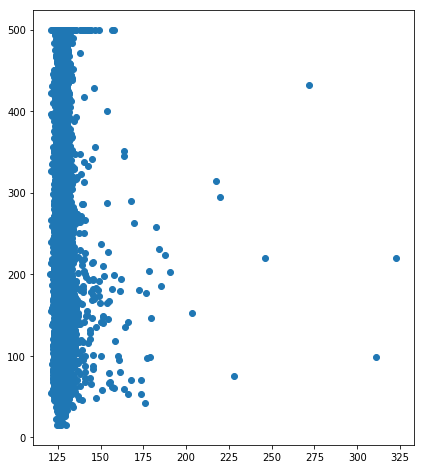

In [21]:
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

 Los datos de calibración muestran la mayoría de los puntos de dispersión alineados con una línea. Esta es casi vertical, pero regresaremos a eso más adelante. Ahora concentrémonos en aquellas que se desvían de la línea. Observamos que la cantidad es relativamente baja.

Si representamos un histograma de `rooms_per_person`, detectamos que tenemos algunos valores atípicos en nuestros datos de entrada:

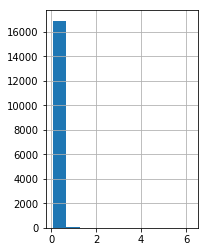

In [22]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

 ## Tarea 3: Ajusta los valores atípicos

Comprueba si puedes mejorar aún más la preparación del modelo al establecer los valores atípicos de `rooms_per_person` en un máximo o mínimo razonables.

Como referencia, aquí se incluye un ejemplo rápido de cómo aplicar una función a una `Series` de Pandas:

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

La `clipped_feature` anterior no tendrá valores inferiores a `0`.

In [0]:
# YOUR CODE HERE

 ### Solución

Haz clic más abajo para conocer la solución.

 El histograma que creamos en la Tarea 2 muestra que la mayoría de los valores son inferiores a `5`. Ajustemos `rooms_per_person` en 5 y representemos un histograma para volver a comprobar los resultados.

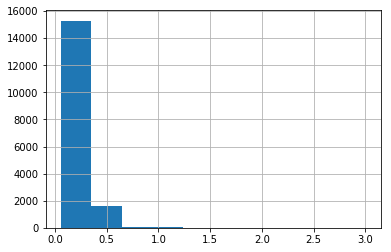

In [27]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5)
                                                           )

_ = california_housing_dataframe["rooms_per_person"].hist()

 Para verificar si funcionó el límite aplicado, volvamos a realizar el entrenamiento e imprimamos los datos de calibración una vez más:

In [0]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

Training model...
RMSE (on training data):
  period 09 : 140.30
Model training finished.


In [0]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])